<a href="https://colab.research.google.com/github/microprediction/monteprediction_colab_examples/blob/main/hey_seriation_sectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hey Seriation

I asked the new ChatGPT-o1 Preview to perform seriation of the following sectors, placing those that are similar next to each other and conversely. You might want to try to do this yourself, using your own common sense.

In [13]:
common_sense_ordering = [
    'XLK',   # Information Technology (IT) - Technology-driven and innovation-focused
    'XLC',   # Communication Services (CS) - Digital infrastructure and content
    'XLY',   # Consumer Discretionary (CD) - Sensitive to economic cycles and consumer spending
    'XLF',   # Financials (F) - Tied to economic expansion and interest rates
    'XLI',   # Industrials (I) - Driven by industrial production and infrastructure
    'XLB',   # Materials (M) - Sensitive to global demand for raw materials
    'XLE',   # Energy (E) - Tied to commodity prices and global energy demand
    'XLP',   # Consumer Staples (CS) - Defensive, providing essential products
    'XLV',   # Health Care (HC) - Defensive, providing essential health services
    'XLU',   # Utilities (U) - Defensive, essential services, less volatile
    'XLRE'   # Real Estate (RE) - A bridge between economic cyclicality and defensive sectors
]


Explanation of Ticker Ordering (from GPT)

* Technology and Communication Services are placed first due to their focus on innovation and digital infrastructure.

* Consumer Discretionary and Financials are cyclical sectors, driven by consumer spending and economic cycles.

* Industrials, Materials, and Energy are resource-dependent sectors, sensitive to global demand and commodity prices.

* Consumer Staples, Health Care, and Utilities are defensive sectors that provide essential goods and services.

* Real Estate acts as a bridge, influenced by both economic growth and interest rates.





# Does common sense help?



[*********************100%***********************]  11 of 11 completed
<ipython-input-12-d7464b930875>:32: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  returns['Month'] = returns.index.to_period('M')


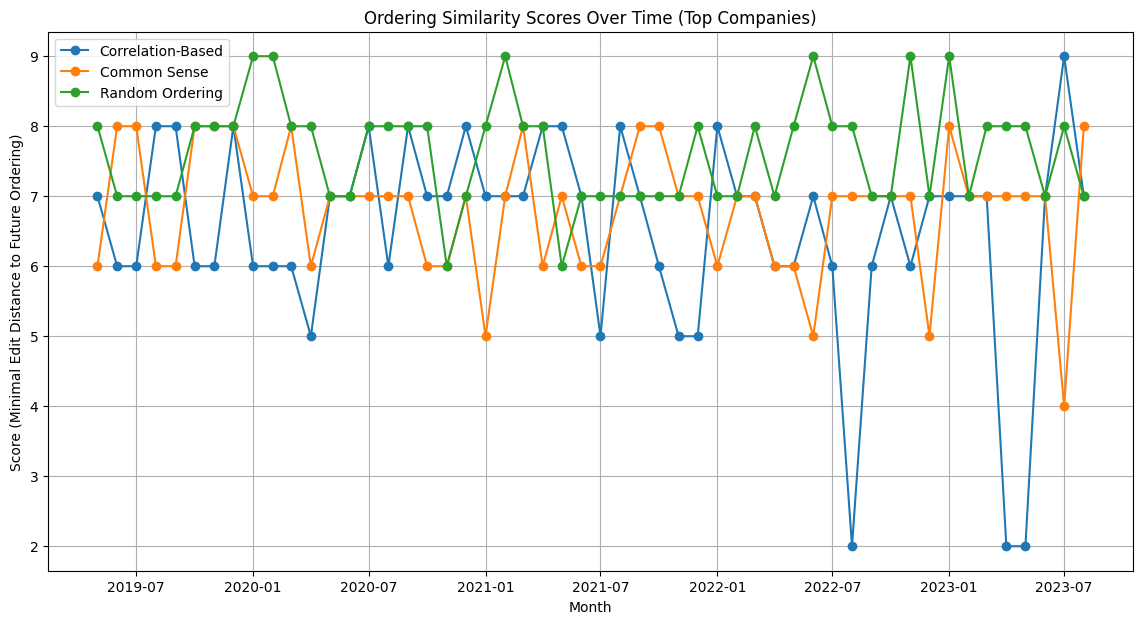

                      Score
Type                       
Common Sense       6.807692
Correlation-Based  6.519231
Random Ordering    7.615385


In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
import random


# Define window size (in months) for rolling correlation
window_size = 6           # Months for current correlation rolling window
future_window_size = 6    # For future ordering (can adjust) that determines seriation target

# Set a seed for reproducibility, or not
random.seed(42)
np.random.seed(42)

# Assuming the companies dictionary is already defined
company_tickers = common_sense_ordering

# Define start and end dates
start_date = '2008-01-01'
end_date = '2023-09-30'

# Download adjusted close prices
prices = yf.download(company_tickers, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
returns = prices.pct_change().dropna()

# Add Month column
returns['Month'] = returns.index.to_period('M')

# Get list of unique months
months = returns['Month'].unique()

# Initialize lists to store current and future orderings
current_orderings = []
future_orderings = []

# Loop over months, ensuring we have enough future data
for i in range(window_size - 1, len(months) - future_window_size - 1):  # Adjust to ensure no overlap
    # Get the current month
    current_month = months[i]

    # Get the start month for the rolling window
    start_month = months[i - (window_size - 1)]

    # Get the data from start_month to current_month (inclusive)
    mask_current = (returns['Month'] >= start_month) & (returns['Month'] <= current_month)
    window_data_current = returns.loc[mask_current, company_tickers]

    # Compute the correlation matrix for current ordering
    corr_matrix_current = window_data_current.corr()

    # Convert correlations to distances
    distance_matrix_current = 1 - corr_matrix_current
    dist_array_current = squareform(distance_matrix_current.values, checks=False)

    # Perform hierarchical clustering for current ordering
    linkage_matrix_current = linkage(dist_array_current, method='average')
    leaves_current = leaves_list(linkage_matrix_current)
    ordering_current = corr_matrix_current.columns[leaves_current]

    # Append the current ordering and the current month
    current_orderings.append((current_month, list(ordering_current)))

    # Get the start and end months for the future ordering (strictly after the current window)
    start_future_month = months[i + 1]
    end_future_month = months[i + future_window_size]

    # Get the data for the future period (future_window_size months after the current window)
    mask_future = (returns['Month'] >= start_future_month) & (returns['Month'] <= end_future_month)
    window_data_future = returns.loc[mask_future, company_tickers]

    # Compute the correlation matrix for future ordering
    corr_matrix_future = window_data_future.corr()

    # Convert correlations to distances
    distance_matrix_future = 1 - corr_matrix_future
    dist_array_future = squareform(distance_matrix_future.values, checks=False)

    # Perform hierarchical clustering for future ordering
    linkage_matrix_future = linkage(dist_array_future, method='average')
    leaves_future = leaves_list(linkage_matrix_future)
    ordering_future = corr_matrix_future.columns[leaves_future]

    # Append the future ordering and the next month
    future_orderings.append((end_future_month, list(ordering_future)))  # Use end of future window

# Function to generate all cyclic permutations and their reverses
def generate_cyclic_permutations(ordering):
    perms = []
    N = len(ordering)
    for i in range(N):
        # Cyclic permutation
        perm = ordering[i:] + ordering[:i]
        perms.append(perm)
        # Reverse cyclic permutation
        perm_rev = perm[::-1]
        perms.append(perm_rev)
    return perms

# Function to compute Hamming distance between two orderings
def hamming_distance(order1, order2):
    return sum(el1 != el2 for el1, el2 in zip(order1, order2))


# Generate a fixed random ordering
random_ordering = company_tickers.copy()
np.random.shuffle(random_ordering)

# Compute scores between the current ordering and future ordering
corr_scores = []

for (curr_month, curr_ordering), (future_month, future_ordering) in zip(current_orderings, future_orderings):
    # Generate all cyclic permutations of current ordering and their reverses
    cyclic_perms = generate_cyclic_permutations(curr_ordering)

    # Compute the minimal Hamming distance to the future ordering
    min_distance = np.inf
    for perm in cyclic_perms:
        dist = hamming_distance(perm, future_ordering)
        if dist < min_distance:
            min_distance = dist
    # Store the score and the month (associate with future_month)
    corr_scores.append((future_month.to_timestamp(), min_distance))

# Compute scores between the common sense ordering and future ordering
cs_scores = []

for (future_month, future_ordering) in future_orderings:
    # Generate all cyclic permutations of the common sense ordering and their reverses
    cyclic_perms = generate_cyclic_permutations(common_sense_ordering)

    # Compute the minimal Hamming distance to the future ordering
    min_distance = np.inf
    for perm in cyclic_perms:
        dist = hamming_distance(perm, future_ordering)
        if dist < min_distance:
            min_distance = dist
    # Store the score and the month
    cs_scores.append((future_month.to_timestamp(), min_distance))

# Compute scores between the random ordering and future ordering
random_scores = []

for (future_month, future_ordering) in future_orderings:
    # Generate all cyclic permutations of the random ordering and their reverses
    cyclic_perms = generate_cyclic_permutations(random_ordering)

    # Compute the minimal Hamming distance to the future ordering
    min_distance = np.inf
    for perm in cyclic_perms:
        dist = hamming_distance(perm, future_ordering)
        if dist < min_distance:
            min_distance = dist
    # Store the score and the month
    random_scores.append((future_month.to_timestamp(), min_distance))

# Convert scores to DataFrames
cs_scores_df = pd.DataFrame(cs_scores, columns=['Month', 'Score'])
cs_scores_df['Type'] = 'Common Sense'

random_scores_df = pd.DataFrame(random_scores, columns=['Month', 'Score'])
random_scores_df['Type'] = 'Random Ordering'

corr_scores_df = pd.DataFrame(corr_scores, columns=['Month', 'Score'])
corr_scores_df['Type'] = 'Correlation-Based'

# Combine the DataFrames
combined_scores_df = pd.concat([cs_scores_df, corr_scores_df, random_scores_df], ignore_index=True)

# Plot the scores over time
plt.figure(figsize=(14,7))
for score_type in ['Correlation-Based', 'Common Sense', 'Random Ordering']:
    subset = combined_scores_df[combined_scores_df['Type'] == score_type]
    plt.plot(subset['Month'], subset['Score'], marker='o', label=score_type)

plt.title('Ordering Similarity Scores Over Time (Top Companies)')
plt.xlabel('Month')
plt.ylabel('Score (Minimal Edit Distance to Future Ordering)')
plt.legend()
plt.grid(True)
plt.show()

# Print the average scores by type
print(combined_scores_df[['Type','Score']].groupby('Type').mean())
